# Домашнее заданиие

1. Необходимо скачать и подготовить датасет
https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks
для обучения модели на сегментацию губ (обратите внимание, что сегментация
подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch

In [83]:
!pip install segmentation_models_pytorch

In [84]:
import zipfile
import os
import time

from google.colab import drive
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch

Загрузим данные с гугл-диска

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [85]:
data_path = '/content/drive/MyDrive/Makeup. Pixel Perfect Lips Segmentation..zip'

In [86]:
zip_file = zipfile.ZipFile(data_path, 'r')
zip_file.extractall()

print(os.listdir())

['.config', 'set-lipstick-original', 'drive', 'sample_data']


In [87]:
dir = 'set-lipstick-original'

In [88]:
list_dir = os.listdir('set-lipstick-original')
list_dir

['720p', 'list.csv', 'mask']

In [89]:
df_dir = 'set-lipstick-original/list.csv'
image_dir = 'set-lipstick-original/720p'
mask_dir = 'set-lipstick-original/mask'

In [90]:
df_data = zipfile.ZipFile.extract(zip_file, member = 'set-lipstick-original/list.csv')

Сделаем датафрейм из файла csv

In [91]:
df = pd.read_csv(df_data)
df.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png


In [92]:
df.shape

(28594, 9)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   width     28594 non-null  int64 
 2   height    28594 non-null  int64 
 3   class     28594 non-null  object
 4   xmin      28594 non-null  int64 
 5   ymin      28594 non-null  int64 
 6   xmax      28594 non-null  int64 
 7   ymax      28594 non-null  int64 
 8   mask      28594 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


Создаем кастомный класс Датасета

In [269]:
class LipsSegDataset(torch.utils.data.DataLoader):
    IMG = 'filename'
    MSK = 'mask'
    
    def __init__(self, mask_dir, image_dir, df, 
                 preprocessing=None, augmentation=None):
        self.mask_dir = mask_dir
        self.image_dir = image_dir
        self.df = df
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        return len(self.df)

    def  __getitem__(self, indx):
        #считываем и ресайзим картинку
        image = cv2.imread(str(image_dir + '/' + self.df.iloc[indx][self.IMG]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        #image = image / 255
        image = image.astype('float32')
        
        #считываем, ресайзим и нормализуем маску
        mask = cv2.imread(str(mask_dir + '/' +self.df.iloc[indx][self.MSK]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))
        mask = mask / 255
        mask = mask.astype('float32')
        mask = torch.as_tensor(mask)
        mask = mask.permute(2,0,1)

        if self.preprocessing:
            image = self.preprocessing(image)
            image = image.astype('float32')
            image = torch.as_tensor(image)
            image = image.permute(2,0,1)
        else:
            # Нормализуем изображение в значениях [0, 1]
            image = torch.as_tensor(image) / 255.0
            image = image.permute(2,0,1)

        if self.augmentation:
            a_sample = self.augmentation(image=image, mask=mask)
            image, mask = a_sample['image'], a_sample['mask']
        
        return torch.as_tensor(image), torch.as_tensor(mask)

               

В датасете есть странность, в папке масок меньше, чем в csv-ном файле. Удалим рахождения

In [ ]:
a=[]
for i in os.listdir(image_dir):
    a.append(i)

In [190]:
b = list(df['mask'])

In [196]:
c = list(set(b) - set(a))

In [198]:
df.shape, len(c)

((28594, 9), 54)

Имеем в датафрейме 54 картинки, которых нет в папке с картинками. Удалим их из датафрейма, чтобы потом не возникло ошибки при обучении

In [200]:
df = df.loc[~df['mask'].isin(c)]

In [201]:
df.shape, len(c)

((28540, 9), 54)

Создадим функцию для визуализации

In [281]:
def visual(**images):
    l = len(images)
    plt.figure(figsize=(20, 8))
    
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, l, i + 1)
#         plt.imshow(image)
        plt.imshow(image.permute(2, 1, 0))
        plt.title(name)

    plt.show()

Разобьем датафрейм на трейн и тест

In [282]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)

# Упорядочиваем индексацию
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [283]:
device = 'cuda:0' if torch.cuda.is_available else 'cpu'
device

'cuda:0'

Создаем модель

In [292]:
import segmentation_models_pytorch as smp
import albumentations as albu

BACKBONE = 'resnet18'
transforms = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

model = smp.PSPNet(encoder_name=BACKBONE, 
               encoder_weights='imagenet', 
               classes=1,
               activation='sigmoid').to(device)


Создаем кастомные датасеты

In [293]:
train_dataset = LipsSegDataset(mask_dir = mask_dir,
                            image_dir=image_dir, 
                            df=df_train,
                            preprocessing=transforms,
                            #augmentation=augmentation
                            )

test_dataset = LipsSegDataset(mask_dir = mask_dir,
                            image_dir=image_dir, 
                            df=df_test,
                            preprocessing=transforms
                            )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


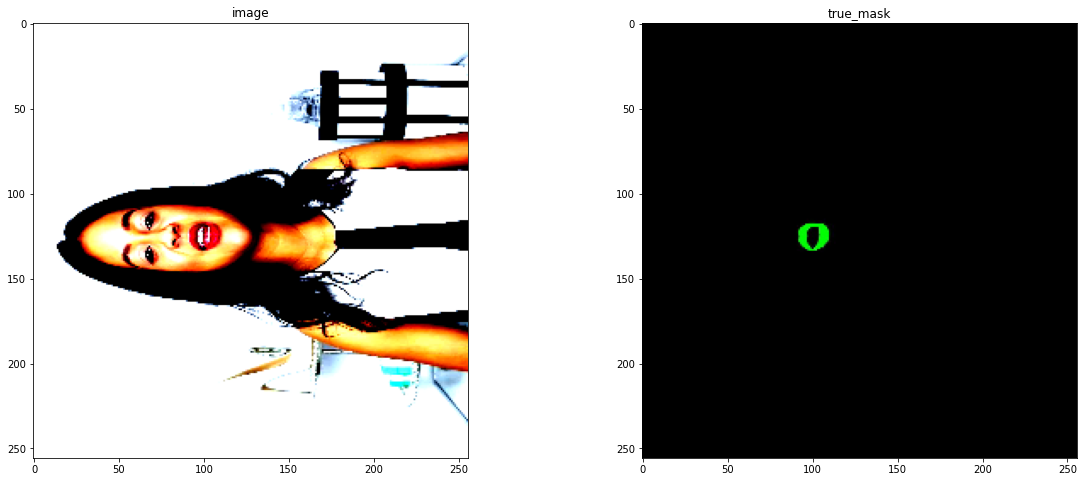

In [294]:
image, mask = train_dataset[16]
image.shape
#plt.imshow(image.permute(0, 1, 2))
visual(image=image, true_mask=mask)

Создаем даталоадеры

In [295]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, num_workers=2)

Функция ошибки, метрики, оптимизатор

In [296]:
criterion = smp.utils.losses.DiceLoss()
metric = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

Параметризируем эпохи обучения и валидации

In [297]:
train_epoch = smp.utils.train.TrainEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         optimizer=optimizer, 
                                         device=device, 
                                         verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         device=device)

Запускаем обучение (одну эпоху)

In [298]:
EPOCHS = 1

for epoch in range(EPOCHS):
    print(f'EPOCHS [{epoch}/{EPOCHS}]:')
    train_score = train_epoch.run(train_dataloader)
    valid_score = valid_epoch.run(test_dataloader)
    
    if valid_score['iou_score'] > 0.92:
        break

EPOCHS [0/1]:
valid: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s, dice_loss - 0.1003, iou_score - 0.821]


А теперь посмотрим, как работает на тестовой выборке.

In [367]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

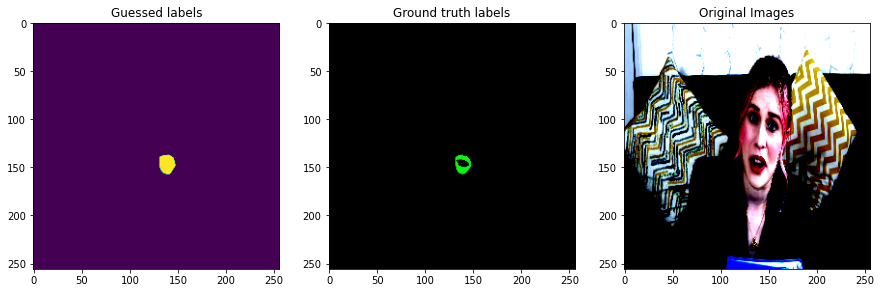

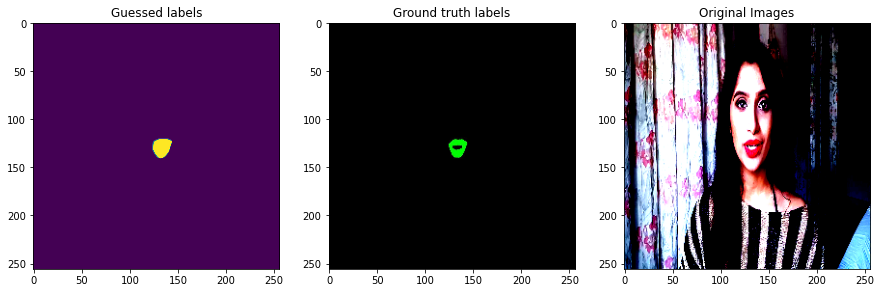

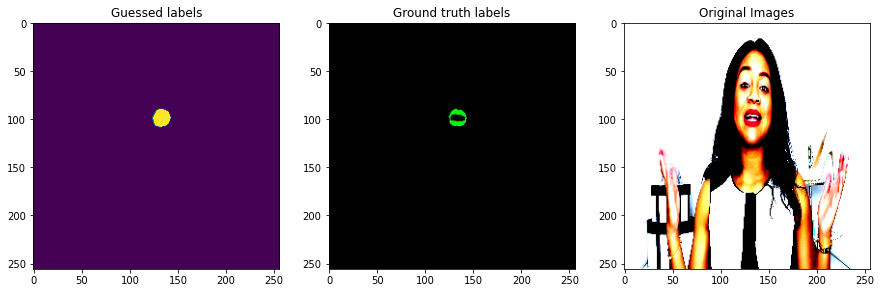

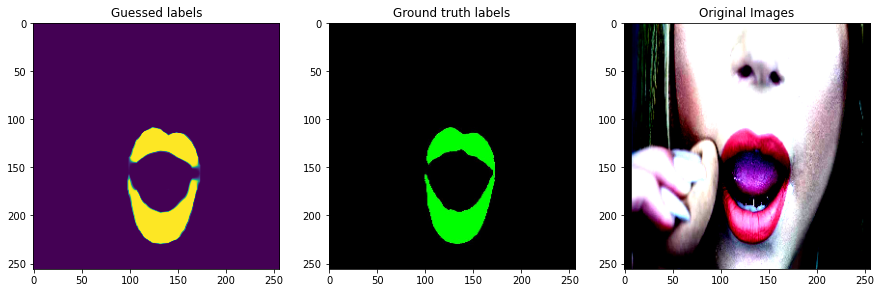

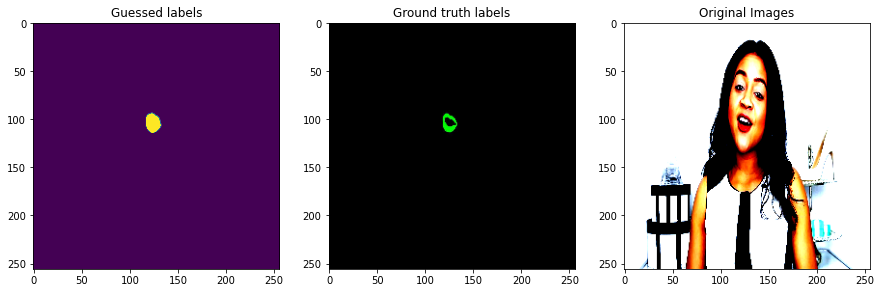

In [371]:
for i, data in enumerate(test_dataloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.swapaxes(1,2)
    labels = labels.swapaxes(2,3)
    outputs = model(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))
    for j in range(0, 16):

        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break

Учитывая только одну эпоху обучения, выглядит неплохо